In [1]:
#import some modules for use later 
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
#these are some constants, in SI units 
Rd=287.04 #dry gas constant
Rv=461.50 #water vapour gast constant 
eps=Rd/Rv #ratio is needed for conversions from p to r 
Cd=3.5*Rd #define heat capacity with ideal gas
Lv=2.26e6 #latent heat of vaporizaytion
Lf=2.83e6 #latent heat of fusion
T0=273.16 #reference temperature 
e0=611 #saturation vapour pressure at reference temperature 
g=9.8 #what you think it is 
Tf=273.15 #freezing temperature 
p0=1e5 #reference surface pressure

In [3]:
#some functions 

#calculate the saturation mixing ratio 
def rstar(T,p,L):
    es=e0*np.exp(-L/Rv*(1./T-1./T0))
    rs=eps*es/(p-es)
    return rs

#this is a function which calculates the derivatives 
#its very very very basic 
#we assume everything is pseudoadiabatic
#(so all the condensed particles are instantly removed)
#and that the bluk properties of the parcel are approximated by the dry air
#(moisture only matters for the purposes of latent heating) 
#for reference y=(O,r,rl,ri)
def dydp_simple(y,p):
    O=y[0]
    r=y[1]
    rl=y[2]
    ri=y[3]
    T=O*np.power(p0/p,-2./7.)
    dydp=np.zeros(4)
    #treat liquid and frozen branches seperately 
    if T>=Tf:
        L=Lv
        rs=rstar(T,p,L)
        if r>=rs:
            dydp[1]=(rs-r)/dp
            dydp[2]=-dydp[1]
            dydp[0]=-O*L/(Cd*T)*dydp[1]
    else:
        L=Lf
        rs=rstar(T,p,L)
        if r>=rs:
            dydp[1]=(rs-r)/dp
            dydp[3]=-dydp[1]
            dydp[0]=O*L/(Cd*T)*dydp[3]
    return dydp 

In [4]:
#this is the part where we actually run the code 

#set up the pressure grid 
p=np.linspace(1e5,2e4,200)
dp=p[1]-p[0]

#some surface conditions 
O0=300
r0=1e-3
L=Lv
rs=rstar(O0,p[0],L)
H=0.8

#define the data container and intialize it 
y=np.zeros([4,len(p)])
y[0,0]=O0
y[1,0]=rs*H

#advance the loop through the pressure grid 
for ii in range(1,len(p)):
    y[:,ii]=y[:,ii-1]+dydp_simple(y[:,ii-1],p[ii-1])*dp

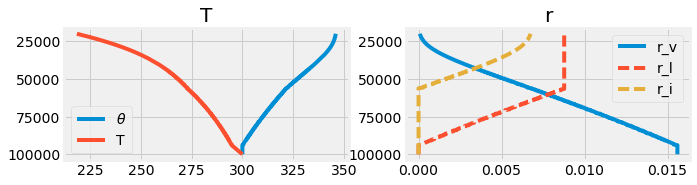

In [7]:
#the variables plotted in blue are actually used in the integration
#everything else is for diagnostic purposes

T=y[0]*np.power(p0/p,-2./7.)

plt.style.use('fivethirtyeight')
plt.figure(0,figsize=(10,5),facecolor='white')

plt.subplot(2,2,1)
plt.plot(y[0],p,label='$\\theta$')
plt.plot(T,p,label='T')
plt.title('T')
plt.legend()
plt.gca().invert_yaxis()

plt.subplot(2,2,2)
plt.title('r')
plt.plot(y[1],p,label='r_v')
plt.plot(y[2],p,'--',label='r_l')
plt.plot(y[3],p,'--',label='r_i')
plt.gca().invert_yaxis()
plt.legend()

plt.show()

In [8]:
#this code just iterates the previous code over a grid of initial conditions.

#short helper function to integrate to some final height 
def get_final_conditions(y0,p):
    dp=p[1]-p[0]
    y=np.zeros([4,len(p)])
    y[:,0]=y0
    for ii in range(1,len(p)):
        y[:,ii]=y[:,ii-1]+dydp_simple(y[:,ii-1],p[ii-1])*dp
    return y[:,-1]

#this code evaluates gets Y at some final pressure over some grid of surface temperature and relative humidity
def evaluate_grid(tg,h,p):
    dp=p[1]-p[0]
    Y=np.zeros([len(tg),len(hg),4])
    for ii in range(0,len(tg)):
        for jj in range(0,len(hg)):
            if tg[ii]>=Tf:
                L=Lv
            else:
                L=Lf
            rs=rstar(tg[ii],p0,L)
            y0=np.zeros(4)
            y0[0]=tg[ii]
            y0[1]=eps*(hg[jj]*rs/(1+eps))/(1-hg[jj]*rs/(1+eps)) #sets a mixing ratio with a given surface relative humidity
            Y[ii,jj]=get_final_conditions(y0,p)
    return Y

In [11]:
#this is some code to evaluate the theta at the top of its ascent for a bunch of surface conditions
#the first time it runs normally 
#the second time it runs assuming that Lf=Lv, which effectively eliminates freezing from the model 
#the difference between these two is the difference in entropy production attributable to freezing 
tg=np.linspace(250,310,20)
hg=np.linspace(0,1,20)
p=np.linspace(1e5,2e4,200)
Y=evaluate_grid(tg,hg,p)
Lf_true=Lf
Lf=Lv
Y2=evaluate_grid(tg,hg,p)
Lf=Lf_true #make sure to resest it in case I add more cells later 

2830000.0
2260000.0
2830000.0


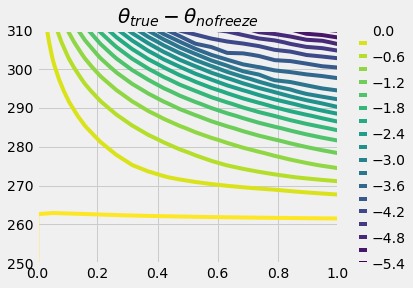

In [18]:
plt.contour(hg,tg,Y2[:,:,0]-Y[:,:,0],20)
plt.title('$\\theta_{true}-\\theta_{nofreeze}$')
plt.colorbar()
plt.show()